## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)

<hr style="height:1px;border-top:4px solid #FF8200" />

# Working with Spectrum Images


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Content

Plotting, Interacting and Quantifying Spectrum Image data

Please cite for core-loss quantification:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

from scipy.ndimage.filters import gaussian_filter

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.EELS_tools  as eels 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
windows
pyTEM version:  0.6.2019.5


# Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

<IPython.core.display.Javascript object>


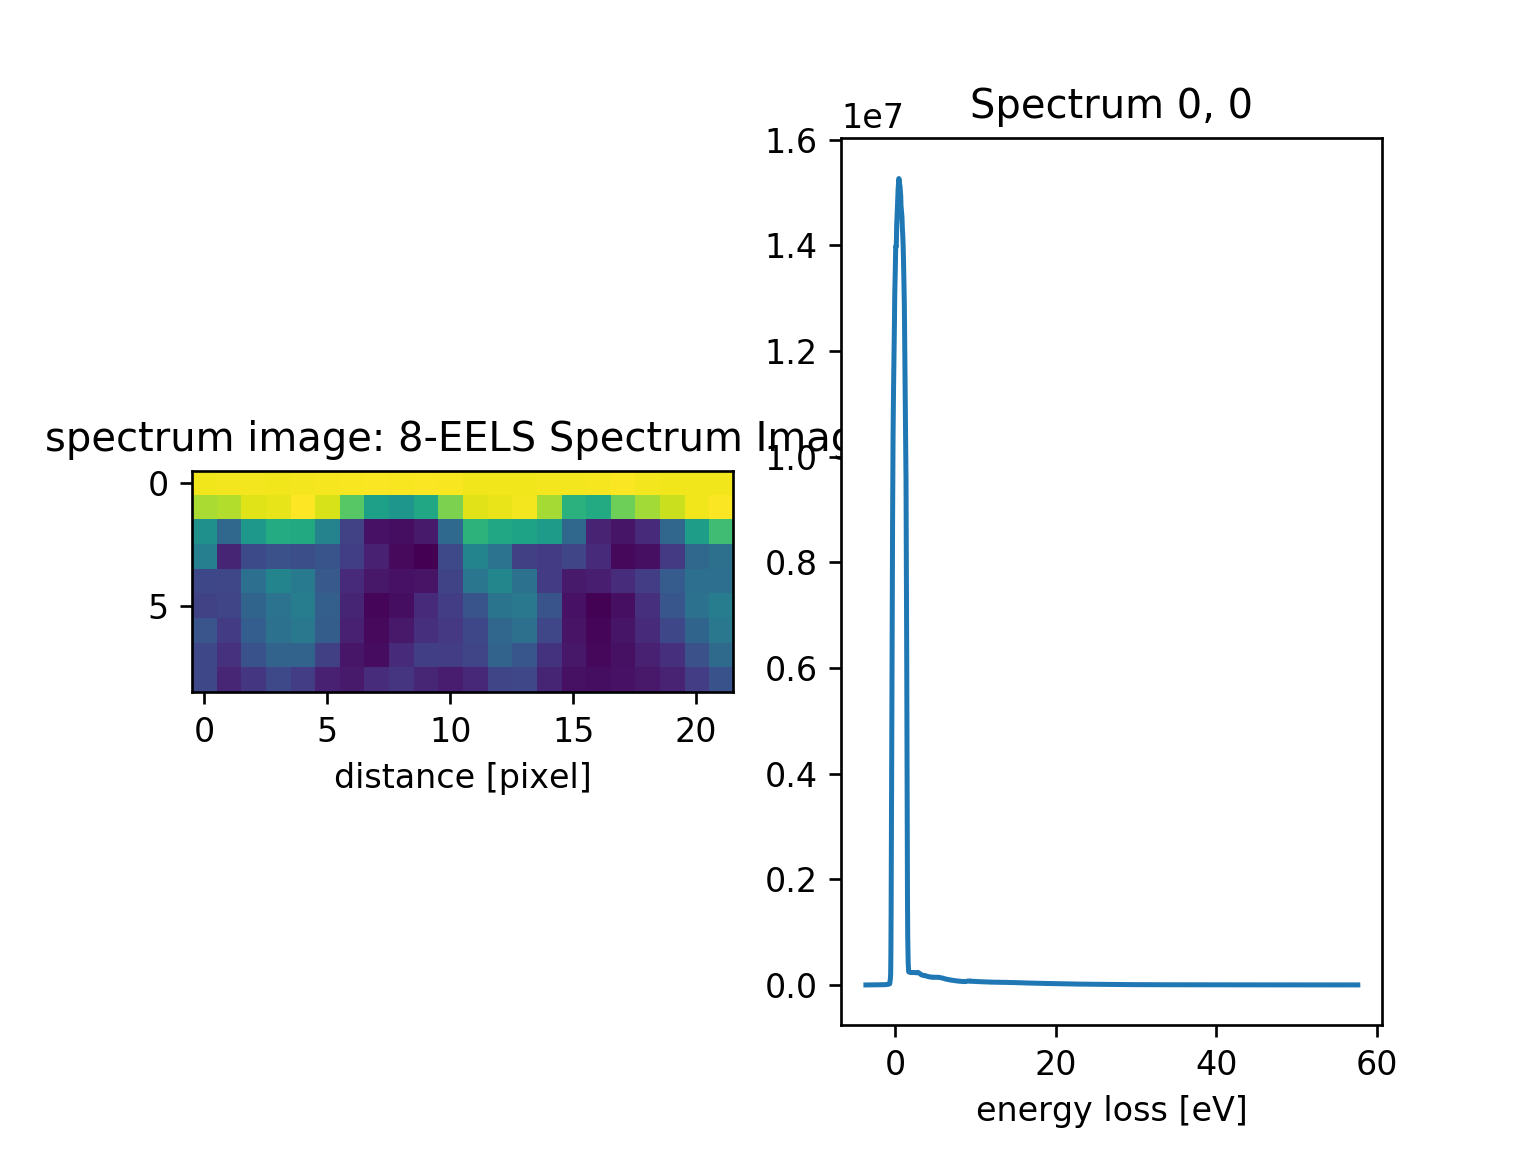

In [2]:
# Load file
try:
    h5_file.close()
    pass
except:
    pass
h5_file = ft.h5_open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)
energy_scale_orig = tags['energy_scale']


# plot data


if tags['data_type']== 'spectrum_image':
    tags['image'] = tags['data']
    tags['data'] = tags['cube'][0,0,:]
    if 'intentsity_scale_ppm' not  in current_channel:
        current_channel['intentsity_scale_ppm'] = 1
    
    
else:    
    
    print('NOT what we want here, please select a spectrum image ')
#ft.h5_plot(current_channel)
    


In [48]:
if tags['data_type']== 'spectrum_image':
    tags['image'] = tags['data']
    tags['data'] = tags['cube'][0,0,:]
    if 'intentsity_scale_ppm' not  in current_channel:
        current_channel['intentsity_scale_ppm'] = 1
        
    tags['ylabel'] = 'intensity [a.u.]'
    tags['spectra'] = {}
    for x in range(tags['spatial_size_y']):
        for y in range(tags['spatial_size_x']):
            tags['spectra'][f'{x}-{y}'] ={}
            tags['spectra'][f'{x}-{y}']['spectrum'] = tags['cube'][y,x,:]
            tags['spectra'][f'{x}-{y}']['energy_scale'] = tags['energy_scale']
            tags['spectra'][f'{x}-{y}']['intensity_scale'] = 1/tags['cube'][y,x,:].sum()*1e6
    tags['ylabel'] = 'inel. scat. int.  [ppm]'
    

for x in range(tags['spatial_size_y']):
    for y in range(tags['spatial_size_x']):
        spectrum = tags['spectra'][f'{x}-{y}']['spectrum']
        energy_scale = tags['spectra'][f'{x}-{y}']['energy_scale']
        FWHM, dE = eels.fixE(spectrum, energy_scale)
        
        tags['spectra'][f'{x}-{y}']['energy_scale'] = energy_scale-dE
        tags['spectra'][f'{x}-{y}']['FWHM'] = FWHM
            

## Interactive Spectrum image Plot:
   
Here is the code that makes the plot interactive

<IPython.core.display.Javascript object>


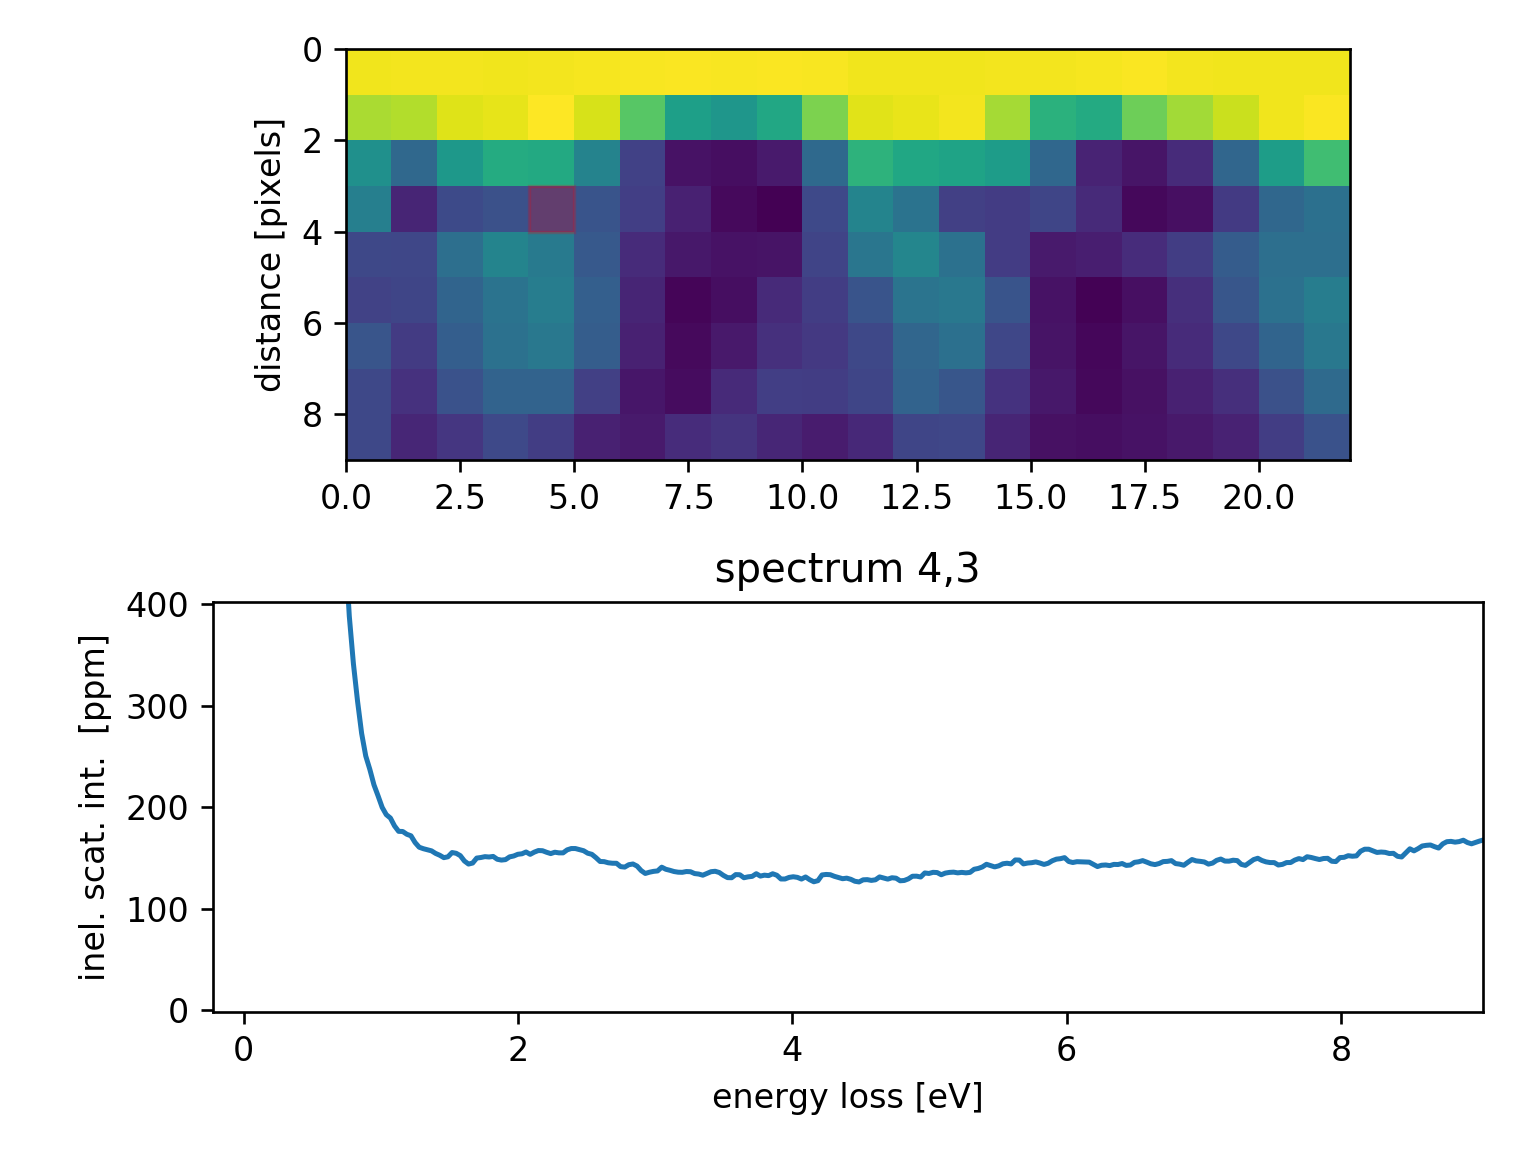

In [50]:
import matplotlib.patches as patches
class interactive_spectrum_image(object):
    def __init__(self, tags, horizontal = True):
        self.figure = plt.figure()
        self.horizontal = horizontal
        self.x = 0
        self.y = 0
        self.tags = tags
        self.extent = [0,tags['cube'].shape[1],tags['cube'].shape[0],0]
        self.rectangle = [0,tags['cube'].shape[1],0, tags['cube'].shape[0]]
        self.scaleX = 1.0
        self.scaleY = 1.0
        if 'ylabel' not in tags:
            tags['ylabel'] = 'intensity [a.u.]'
        self.SI = False
        
        if horizontal:
            self.ax1=plt.subplot(1, 2, 1)
            self.ax2=plt.subplot(1, 2, 2)
        else:
            self.ax1=plt.subplot(2, 1, 1)
            self.ax2=plt.subplot(2, 1, 2)
            
        self.cube = tags['cube']
        self.image = tags['cube'].sum(axis=2)
        
        self.ax1.imshow(self.image, extent = self.extent)
        if horizontal:
            self.ax1.set_xlabel('distance [pixels]')
        else:
            self.ax1.set_ylabel('distance [pixels]')
        self.ax1.set_aspect('equal')
        
        self.rect = patches.Rectangle((0,0),1,1,linewidth=1,edgecolor='r',facecolor='red', alpha = 0.2)
        self.ax1.add_patch(self.rect)
        self.intensity_scale = tags['spectra'][f'{self.x}-{self.y}']['intensity_scale']
        self.spectrum = tags['spectra'][f'{self.x}-{self.y}']['spectrum']* self.intensity_scale
        self.energy_scale = tags['spectra'][f'{self.x}-{self.y}']['energy_scale']
        
        self.ax2.plot(self.energy_scale,self.spectrum)
        self.ax2.set_title(f' spectrum {x},{y} ')
        self.ax2.set_xlabel('energy loss [eV]')
        self.ax2.set_ylabel(tags['ylabel'])
        self.cid = self.figure.canvas.mpl_connect('button_press_event', self.onclick)
        plt.tight_layout()

    def onclick(self,event):
        x = int(event.xdata)
        y = int(event.ydata)
        
        print(x,y)
        if x >= self.rectangle[0] and x < self.rectangle[0]+self.rectangle[1]:
            if y >= self.rectangle[2] and y < self.rectangle[2]+self.rectangle[3]:
                self.x = int((x - self.rectangle[0])/ self.rectangle[1]*self.cube.shape[1])
                self.y = int((y - self.rectangle[2])/ self.rectangle[3]*self.cube.shape[0])
            else:
                return
        else:
            return
        
        
        if event.inaxes in [self.ax1]:
            x = (self.x * self.rectangle[1]/self.cube.shape[1]+ self.rectangle[0])
            y = (self.y * self.rectangle[3]/self.cube.shape[0]+ self.rectangle[2])
            
            self.rect.set_xy([x,y]) 
            xlim = self.ax2.get_xlim()
            ylim = self.ax2.get_ylim()
            self.ax2.clear()
            self.intensity_scale = tags['spectra'][f'{self.x}-{self.y}']['intensity_scale']
            self.spectrum = tags['spectra'][f'{self.x}-{self.y}']['spectrum']* self.intensity_scale
            self.energy_scale = tags['spectra'][f'{self.x}-{self.y}']['energy_scale']

            self.ax2.plot(self.energy_scale,self.spectrum)

            self.ax2.set_title(f' spectrum {self.x},{self.y} ')
            self.ax2.set_xlim(xlim)
            self.ax2.set_ylim(ylim)
            self.ax2.set_xlabel('energy loss [eV]')
            self.ax2.set_ylabel(tags['ylabel'])
            
        self.ax2.draw()
    def get_xy(self):
        return [self.x,self.y]
    
    def get_current_spectrum(self):
        return self.cube[self.y,self.x,:]
    
    def set_Zcontrast_image(self,Z_channel=None):
        if Z_channel != None:
            tags['survey_channel']=Z_channel
        if 'Zcontrast_channel' not in tags:
            print('add Z contrast channel group to dictionary first!')
            return
        # get dictionary from current channel in pyUSID file
        Z_tags = ft.h5_get_dictionary(Z_channel)
        Z_file.close()
        self.ax1.imshow(Z_tags['data'], extent = self.extent, cmap='gray')
        
    def overlay_Zcontrast_image(self,Z_channel=None):
        
        if self.SI:
            if Z_channel != None:
                tags['survey_channel']=Z_channel
            if 'Zcontrast_channel' not in tags:
                print('add survey channel group to dictionary first!')
                return

            Z_tags = ft.h5_get_dictionary(tags['Z-contrast_channel'])

            xlim = self.ax1.get_xlim()
            ylim = self.ax1.get_ylim()
            extent = [self.rectangle[0],self.rectangle[0]+self.rectangle[1],
                      self.rectangle[2]+self.rectangle[3],self.rectangle[2]]
            self.ax1.imshow(Z_tags['data'], extent = extent, cmap='viridis',alpha = 0.5)
            self.ax1.set_ylim(ylim)
            self.ax1.set_xlim(xlim)
            
    def overlay_data(self,data= None):
    
        if self.SI:
            if data ==None:
                data = self.cube.sum(axis=2)
        
            xlim = self.ax1.get_xlim()
            ylim = self.ax1.get_ylim()
            extent = [self.rectangle[0],self.rectangle[0]+self.rectangle[1],
                      self.rectangle[2]+self.rectangle[3],self.rectangle[2]]
            self.ax1.imshow(data, extent = extent,alpha = 0.7, cmap = 'viridis')
            self.ax1.set_ylim(ylim)
            self.ax1.set_xlim(xlim)
        
        
    def set_Survey_image(self, SI_channel = None):
        
        # get dictionary from current channel in pyUSID file
        if SI_channel != None:
            tags['survey_channel']=SI_channel
        if 'survey_channel' not in tags:
            print('add survey channel group to dictionary first!')
            return
        SI_channel = tags['survey_channel'] 
        SI_tags = ft.h5_get_dictionary(SI_channel)
        tags2 = dict(SI_channel.attrs)
        
        self.ax1.set_aspect('equal')
        self.scaleX = SI_channel['spatial_scale_x'][()]
        self.scaleY = SI_channel['spatial_scale_y'][()]
        
        self.ax1.imshow(SI_tags['data'], extent = SI_tags['extent'], cmap = 'gray')
        if self.horizontal:
            self.ax1.set_xlabel('distance [nm]')
        else:
            self.ax1.set_ylabel('distance [nm]')
        
        annotation_done = []
        for key in tags2:
            if 'annotations' in key:
                annotation_number = key[12]
                if annotation_number not in annotation_done:
                    annotation_done.append(annotation_number)
                    
                    if tags2['annotations_'+annotation_number+'_type'] == 'text':
                        x =tags2['annotations_'+annotation_number+'_x'] 
                        y = tags2['annotations_'+annotation_number+'_y']
                        text = tags2['annotations_'+annotation_number+'_text'] 
                        self.ax1.text(x,y,text,color='r')

                    elif tags2['annotations_'+annotation_number+'_type'] == 'circle':
                        radius = 20 * scaleX#tags['annotations'][key]['radius']
                        xy = tags2['annotations_'+annotation_number+'_position']
                        circle = patches.Circle(xy, radius, color='r',fill = False)
                        self.ax1.add_artist(circle)

                    elif tags2['annotations_'+annotation_number+'_type'] == 'spectrum image':
                        width = tags2['annotations_'+annotation_number+'_width'] 
                        height = tags2['annotations_'+annotation_number+'_height']
                        position = tags2['annotations_'+annotation_number+'_position']
                        rectangle = patches.Rectangle(position, width, height, color='r',fill = False)
                        self.rectangle = [position[0], width, position[1], height]
                        self.ax1.add_artist(rectangle)
                        self.ax1.text(position[0],position[1],'Spectrum Image',color='r')
                        self.rect.set_width(width/self.cube.shape[1])
                        self.rect.set_height(height/self.cube.shape[0])
        self.SI = True
        


SI_plot= interactive_spectrum_image(tags, horizontal =False)

## Interactive Spectrum image Plot:
   
The code above is also available in the EELS tools

<IPython.core.display.Javascript object>


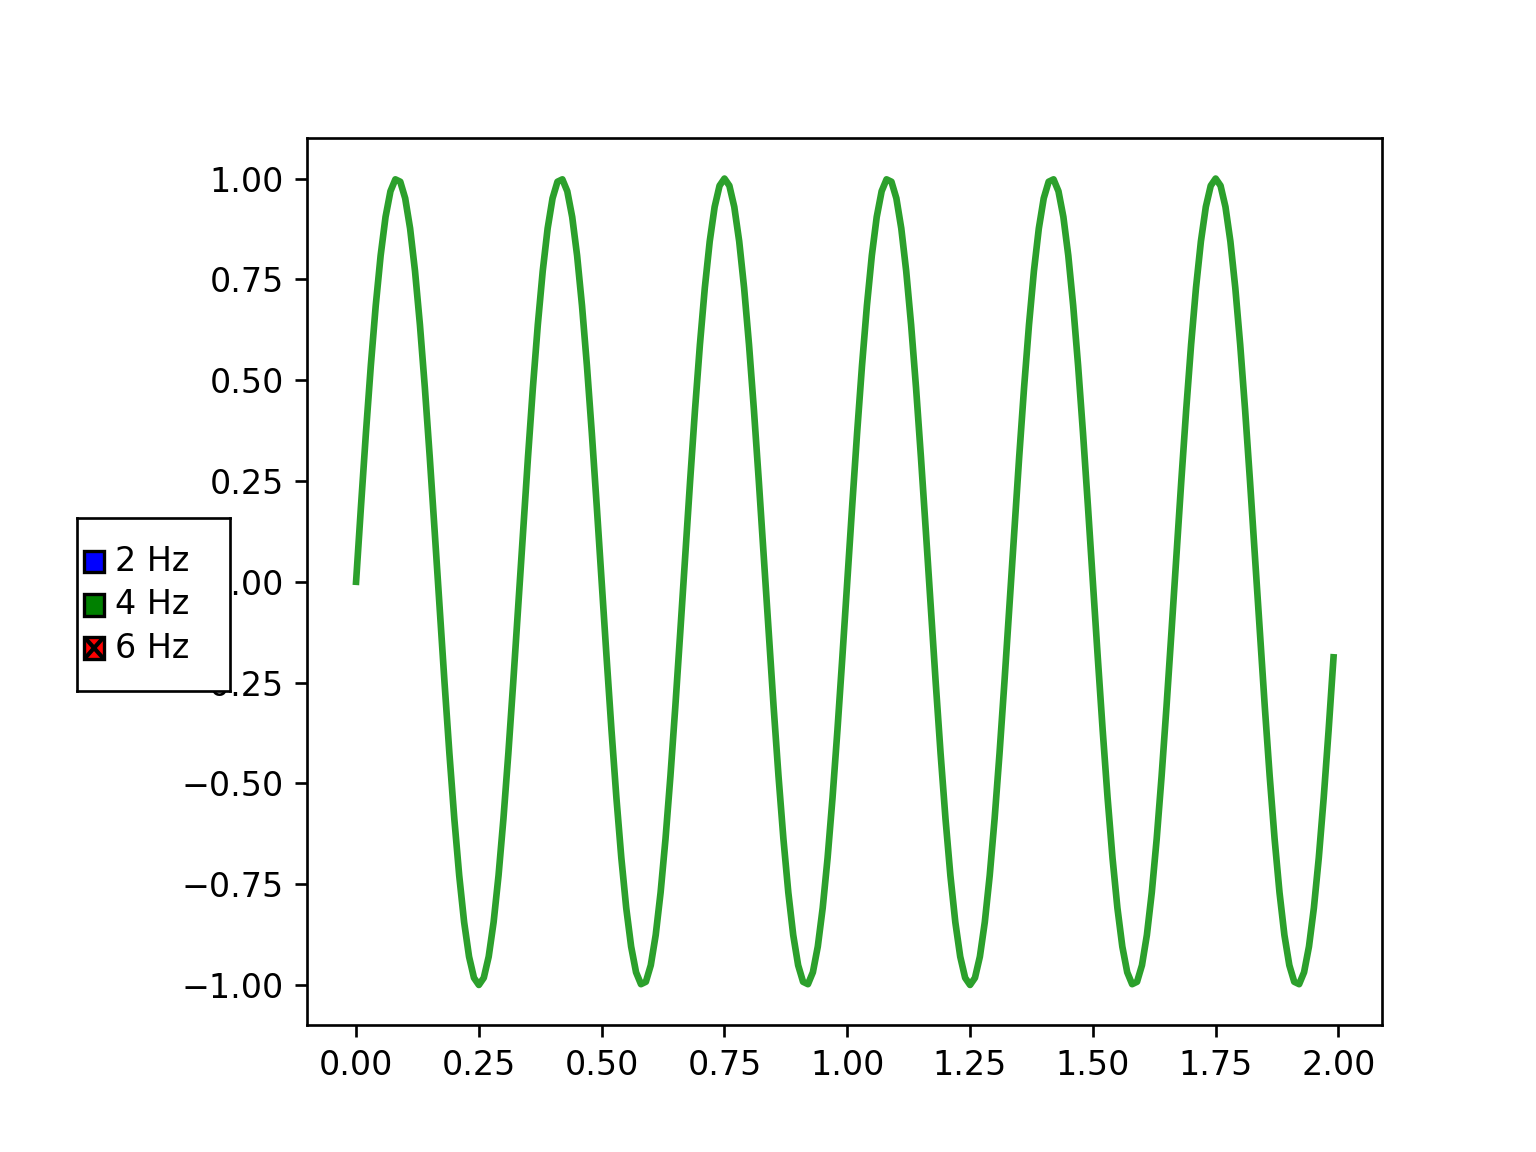

0

In [51]:
from matplotlib.widgets import CheckButtons

t = np.arange(0.0, 2.0, 0.01)
s0 = np.sin(2*np.pi*t)
s1 = np.sin(4*np.pi*t)
s2 = np.sin(6*np.pi*t)

fig, ax = plt.subplots()
l0, = ax.plot(t, s0, visible=False, lw=2)
l1, = ax.plot(t, s1, lw=2)
l2, = ax.plot(t, s2, lw=2)
plt.subplots_adjust(left=0.2)

rax = plt.axes([0.05, 0.4, 0.1, 0.15])
check = CheckButtons(rax, ('2 Hz', '4 Hz', '6 Hz'), (False, True, True))

#Define colours for rectangles and set them
c = ['b', 'g', 'r']    
[rec.set_facecolor(c[i]) for i, rec in enumerate(check.rectangles)]


def func(label):
    if label == '2 Hz': l0.set_visible(not l0.get_visible())
    elif label == '4 Hz': l1.set_visible(not l1.get_visible())
    elif label == '6 Hz': l2.set_visible(not l2.get_visible())
    plt.draw()
check.on_clicked(func)

<IPython.core.display.Javascript object>


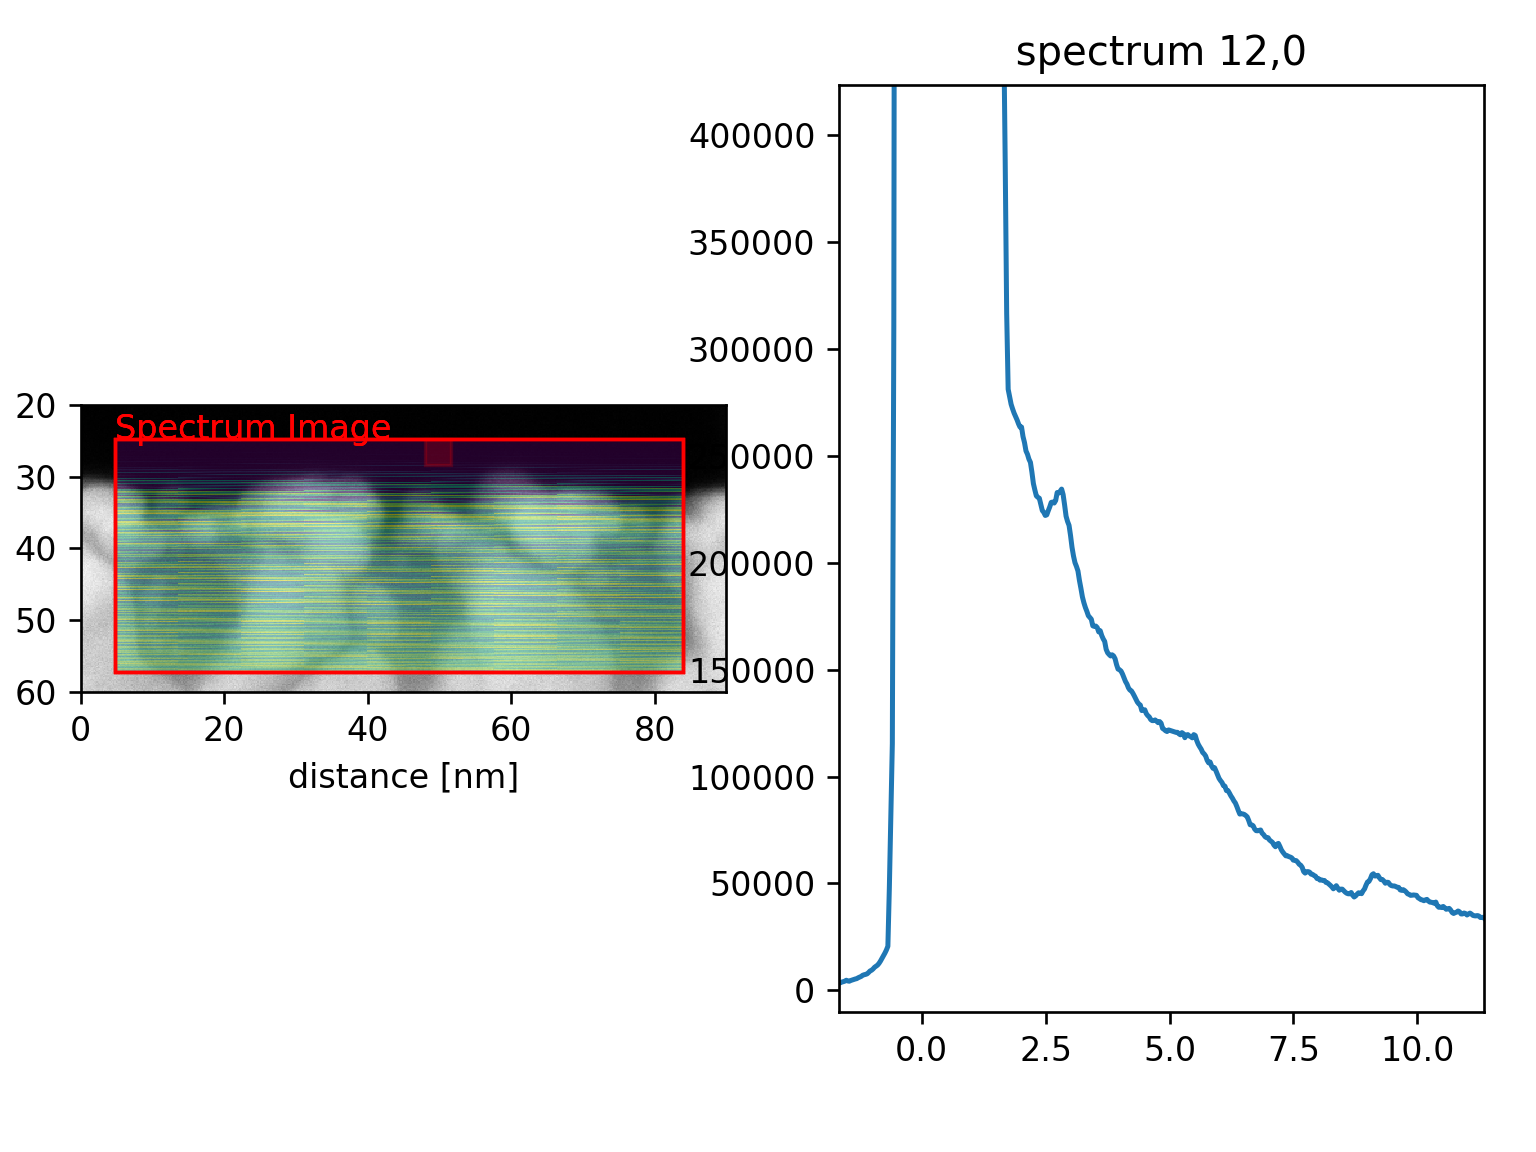

In [27]:
SI_plot= eels.interactive_spectrum_image(tags['cube'],tags['energy_scale'], horizontal =True)


## Add survey image to file

In [44]:

SI_channel = ft.h5_add_channel(h5_file,current_channel,'survey image')    
measurement_group = h5_file[current_channel.name.split('/')[1]]
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ')   
        

Channel_000 :  8-EELS Spectrum Image
Channel_001 :  8-SI Survey Image
Channel_002 :  8-Analog


## Add Survey Image to plot above

I overlay the sum of all spectra on top of the box of the survey image.

Comment that line out (*#SI_plot.overlay_data()*) if you don't want that.

In [45]:
tags['survey_channel'] = h5_file['Measurement_000']['Channel_001']
SI_plot.set_Survey_image()
SI_plot.overlay_data() 

## set view port 
SI_plot.ax1.set_xlim(0,90)
SI_plot.ax1.set_ylim(60,20)


(60, 20)

## Add Z-contrast image

In [6]:
Z_channel = ft.h5add_channel(h5_file,current_channel,'Z-contrast image')
    
measurement_group = h5_file[current_channel.name.split('/')[1]]
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ') 

Channel_000 :  8-EELS Spectrum Image
Channel_001 :  8-SI Survey Image
Channel_002 :  8-Analog


## Overlay Z-contrast image on survey image at plot above

In [30]:
tags['survey_channel'] = h5_file['Measurement_000']['Channel_001']
tags['Zcontrast_channel'] = h5_file['Measurement_000']['Channel_001']

SI_plot.set_Survey_image(h5_file['Measurement_000']['Channel_001'])
SI_plot.overlay_Zcontrast_image(h5_file['Measurement_000']['Channel_002'])

## set view port 
SI_plot.ax1.set_xlim(0,90)
SI_plot.ax1.set_ylim(60,20)


(60, 20)

## Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image (i.e. "Ronchigram" of vacuum)
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

In [3]:
ll_channel = ft.h5_add_channel(h5_file,current_channel,'LL',filename=None)

# get dictionary from current channel in pyUSID file
LLspectrum_tags = ft.h5_get_dictionary(ll_channel)

print(f"{LLspectrum_tags['data'].sum():.0f} counts in  {LLspectrum_tags['integration_time']:.2f}sec")
I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']
print(f"integration time for spectrum was {tags['integration_time']:.2f} s ")

I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']*tags['integration_time']
print(f"incident beam current of core--loss is {I0:.0f} counts")

if 'incident_beam_current_counts' in current_channel:
    current_channel['incident_beam_current_counts'][()] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['incident_beam_current_counts'] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']

    
out_tags ={}
out_tags['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']
if 'intentsity_scale_ppm' in current_channel:
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']


dict_keys(['aberrations', 'exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified', 'title', 'data_type', 'data', 'spectral_scale_x', 'spectral_units_x', 'spectral_origin_x', 'spectral_size_x', 'energy_scale'])


<IPython.core.display.Javascript object>


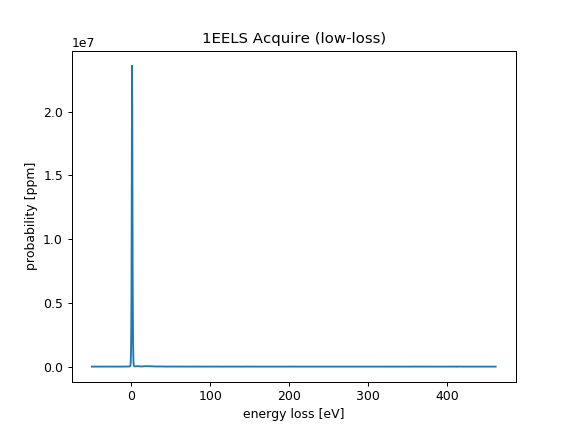

In [4]:
print(LLspectrum_tags.keys())

plt.figure()
plt.title(LLspectrum_tags['title'])
plt.plot(LLspectrum_tags['energy_scale'] , LLspectrum_tags['data'] );
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

<IPython.core.display.Javascript object>


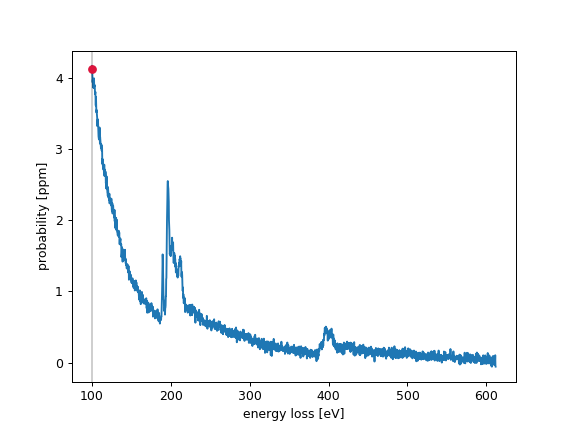

In [3]:


spectrum = tags['data']*current_channel['intentsity_scale_ppm'][()]
plt.figure()
plt.plot(tags['energy_scale'], spectrum)
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Which elements are present

To determine which elements are present we add a cursor to the above plot (see [Working with Cross-Sections](CH4-Working_with_X-Sections.ipynb) for details) and with a left (right) mouse-click, we will get the major (all) edges in the vincinity of the cursor.

In the example we note that the N-K edge of this boron nitride sample is not at 400keV. We have to adjust the energy-scale. <br>(THIS SHOULD NOT HAPPEN IN NORMAL SPECTRA AND IS FOR DEMONSTRATION ONLY)

In [4]:
maximal_chemical_shift = 5
cursor = eels.EdgesatCursor(plt.gca(), tags['energy_scale'],spectrum,maximal_chemical_shift)


Let's correct the energy scale of the example spectrum.

Again a shift of the energy scale is normal but not a discripancy of the dispersion.

## Declaration of Edges
Here we declare which ionization-edges are present. Please make sure that the energy scale is correct!!!



<IPython.core.display.Javascript object>


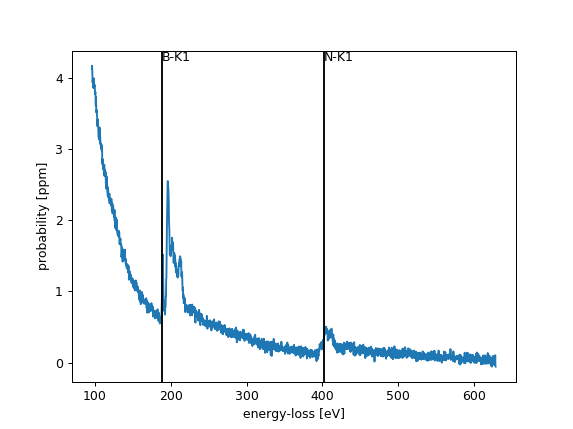

In [5]:
## Input
edges_present = ['B-K','N-K']


tags['energy_scale'] = energy_scale_orig*1.04-8
energy_scale = tags['energy_scale']


edges = eels.make_edges(edges_present, energy_scale, tags['acceleration_voltage'], tags['collection_angle'])

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

plot_edges= []
for key in edges:
    plot_edges.append( eels.elemental_edges(plt.gca(), edges[key]['Z']))

## Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

<IPython.core.display.Javascript object>


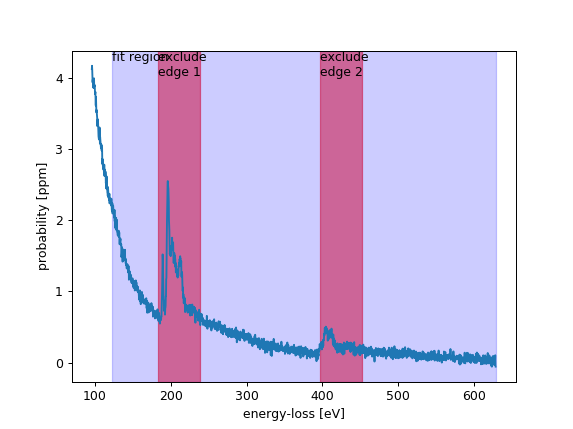

In [8]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = eels.Region_Selector(plt.gca())

for key in edges:
    regions.set_regions(str(key),edges[key]['onset']-edges[key]['start_exclude'], edges[key]['start_exclude']+edges[key]['end_exclude'])
                                  
regions.set_regions('fit region',energy_scale[100], tags['energy_scale'][-1]-energy_scale[100])



## The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.



In [9]:
region_tags = regions.get_regions()
edges = eels.fit_edges(spectrum, energy_scale, region_tags, edges)


print(f"{edges['1']['element']}/{edges['2']['element']} ratio is {edges['1']['areal_density']/edges['2']['areal_density']:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
for key in edges:
    if key.isdigit():
        print(f"{edges[key]['element']} ({edges[key]['Z']}) areal density is {edges[key]['areal_density']:.0f} atoms per square nm, which equates {abs(edges[key]['areal_density'])/18.2:.1f} atomic layers")


B/N ratio is 1.115
B (5) areal density is 98 atoms per square nm, which equates 5.4 atomic layers
N (7) areal density is 88 atoms per square nm, which equates 4.8 atomic layers


## Plotting of the fit


<IPython.core.display.Javascript object>


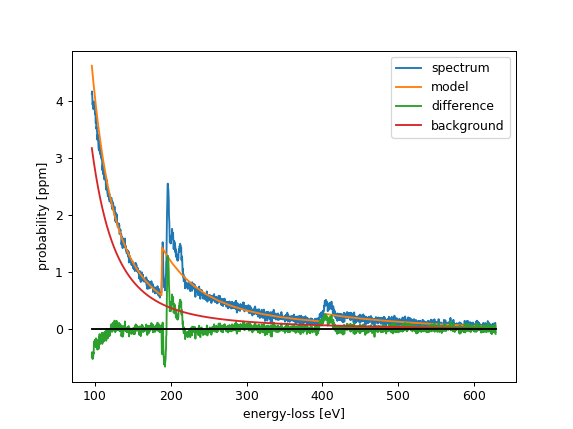

In [10]:

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale,edges['model']['spectrum']*1e6, label='model')
plt.plot(energy_scale,spectrum-edges['model']['spectrum']*1e6, label='difference')
plt.plot(energy_scale,edges['model']['background']*1e6, label='background')
plt.plot([energy_scale[0],energy_scale[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

## Dictionary for Log of Fitting Results

In [11]:
out_tags = {}
for key1 in edges:
    if key1.isdigit():
        for key2 in edges[key1]:
            out_tags[f"edge_{key1}_{key2}"] = edges[key1][key2]
    else:
        for key2 in edges[key1]:
            out_tags[f"{key1}_{key2}"] = edges[key1][key2]

out_tags['monolayer']= 18.2 #atoms/nm^2
out_tags['X_section_unit'] = 'atoms/nm$^2$'

In [12]:
print(out_tags.keys())

dict_keys(['edge_1_Z', 'edge_1_symmetry', 'edge_1_element', 'edge_1_chemcial_shift', 'edge_1_original_onset', 'edge_1_onset', 'edge_1_start_exclude', 'edge_1_end_exclude', 'edge_1_data', 'edge_1_areal_density', 'edge_2_Z', 'edge_2_symmetry', 'edge_2_element', 'edge_2_chemcial_shift', 'edge_2_original_onset', 'edge_2_onset', 'edge_2_start_exclude', 'edge_2_end_exclude', 'edge_2_data', 'edge_2_areal_density', 'model_background', 'model_background-poly_1', 'model_background-poly_2', 'model_background-A', 'model_background-r', 'model_spectrum', 'model_blurred', 'model_mask', 'model_fit_parameter', 'model_fit_area_start', 'model_fit_area_end', 'monolayer', 'X_section_unit'])


## Log Results

In [13]:
log_group = ft.h5_add_Log(current_channel, name='Xsection_fit')
ft.h5_add_Data2Log(log_group,  out_tags)

## Check on File Content

In [14]:
import pyUSID as usid 
usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ X_section_unit
      ├ _Xsection_fit
      ├ edge_1_Z
      ├ edge_1_areal_density
      ├ edge_1_chemcial_shift
      ├ edge_1_data
      ├ edge_1_element
      ├ edge_1_end_exclude
      ├ edge_1_onset
      ├ edge_1_original_onset
      ├ edge_1_start_exclude
      ├ edge_1_symmetry
      ├ edge_2_Z
      ├ edge_2_areal_density
      ├ edge_2_chemcial_shift
      ├ edge_2_data
      ├ edge_2_element
      ├ edge_2_end_exclude
      ├ edge_2_onset
      ├ edge_2_original_onset
      ├ edge_2_start_exclude
      ├ edge_2_symmetry
      ├ model_background
      ├ model_background-A
      ├ model_background-poly_1
      ├ model_background-poly_2
      ├ model_background-r
      ├ model_blurred
      ├ model_fit_area_end
      ├ model_fit_area_start
      ├ model_fit_parameter
      ├ model_mask
      ├ model_spectrum
      ├ monolayer
      ├ time_stamp
      ├ title
    ├ Position_

# Close File
File needs to be closed to be used with other notebooks

In [15]:
h5_file.close()

## Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)
## Next:  [ELNES](ELNES.ipynb)

## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)